In [58]:
''' Import training data and scale to [0.1] and take log10 of values '''
import numpy as np
train = np.load('training_data.npy')
scaler_value = np.load('scaler_value.npy')

# Return to normal scaling
train = train*scaler_value

train = np.where(train<1,1,train) # make all values less than 1 equal to one
train = np.log10(train) # scale logarithmically

for row in range(train.shape[0]):
    train[row] = train[row] / np.max(train[row])

#np.where(x>50,0,1)

In [85]:
''' Import relevant libraries '''
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from keras.callbacks import Callback
import keras.backend as K
import math

In [ ]:
''' fit an LSTM network to training data '''
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons, dropout=0.5):
    
    # make training and validation set lengths divisble by batch num
    len_train = np.floor(train.shape[0]*0.5/n_batch)*n_batch*2
    len_train = len_train.astype(int)
    #print(len_train)
    
    # reshape training into [samples, timesteps, features]
    X, y = train[:len_train, 0:n_lag], train[:len_train, n_lag:]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, recurrent_dropout=dropout))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # define restart schedule
    schedule = SGDRScheduler(min_lr=1e-5,
                        max_lr=1e-2,
                        steps_per_epoch=train.shape[0],
                        lr_decay=0.9,
                        cycle_length=5,
                        mult_factor=1.5)
    
    # fit network
    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, shuffle=True, verbose=1, validation_split=0.5,callbacks=[schedule])
    #model.reset_states()
    
    return model

In [76]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [1]:
n_lag = 120
n_seq = 60
nb_epoch = 5
n_batch = 32   # batch size must be divisible by number of cores (8 in this case)
n_neurons = 32
dropout=0.5

fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons, dropout)

NameError: name 'fit_lstm' is not defined

In [90]:
def fit_multi_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons, dropout, num_models, model_frac):
    # list of models
    models= []
    
    # make training and validation set lengths divisble by batch num
    model_len = model_frac*train.shape[0]
    model_len = math.floor(model_len)
    
    for i in range(num_models):
        # train each model and a random subset of the data
        np.random.shuffle(train)
        model_train=fit_lstm(train[:model_len], n_lag, n_seq, n_batch, nb_epoch, n_neurons, dropout)
        
        # # re-define model but batch size = 1
        model_pred = Sequential()
        model_pred.add(LSTM(n_neurons, batch_input_shape=(1, model_len, 1), stateful=True, recurrent_dropout=dropout))
        model_pred.add(Dense(y.shape[1]))
        model_pred.compile(loss='mean_squared_error', optimizer='adam')
        
        # copy weights
        old_weights = model_train.get_weights()
        model_pred.set_weights(old_weights)
        
        # add prediction model to list
        models.append(model_pred)
    
    return models

In [91]:
n_lag = 120
n_seq = 60
nb_epoch = 5
n_batch = 32   # batch size must be divisible by number of cores (8 in this case)
n_neurons = 16
dropout=0.5
num_models=5 
model_frac=0.5

model_list=fit_multi_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons, dropout, num_models, model_frac)

17984
Train on 8992 samples, validate on 8992 samples
Epoch 1/5
 128/8992 [..............................] - ETA: 1:48 - loss: 0.6206

C:\Users\jramsay\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156515). Check your callbacks.
  % delta_t_median)


8992/8992 [==============================] - 29s 3ms/step - loss: 0.0288 - val_loss: 0.0106
Epoch 2/5
8992/8992 [==============================] - 27s 3ms/step - loss: 0.0094 - val_loss: 0.0076
Epoch 3/5
8992/8992 [==============================] - 27s 3ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 4/5
8992/8992 [==============================] - 27s 3ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 5/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0071 - val_loss: 0.0067
17984
Train on 8992 samples, validate on 8992 samples
Epoch 1/5
 128/8992 [..............................] - ETA: 1:54 - loss: 0.6067

C:\Users\jramsay\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162016). Check your callbacks.
  % delta_t_median)


8992/8992 [==============================] - 29s 3ms/step - loss: 0.0289 - val_loss: 0.0103
Epoch 2/5
8992/8992 [==============================] - 27s 3ms/step - loss: 0.0102 - val_loss: 0.0089
Epoch 3/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 4/5
8992/8992 [==============================] - 28s 3ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 5/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0076 - val_loss: 0.0066
17984
Train on 8992 samples, validate on 8992 samples
Epoch 1/5
 128/8992 [..............................] - ETA: 1:56 - loss: 0.6215

C:\Users\jramsay\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179018). Check your callbacks.
  % delta_t_median)


8992/8992 [==============================] - 30s 3ms/step - loss: 0.0278 - val_loss: 0.0107
Epoch 2/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0101 - val_loss: 0.0080
Epoch 3/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 4/5
8992/8992 [==============================] - 27s 3ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 5/5
8992/8992 [==============================] - 27s 3ms/step - loss: 0.0074 - val_loss: 0.0071
17984
Train on 8992 samples, validate on 8992 samples
Epoch 1/5
 128/8992 [..............................] - ETA: 1:58 - loss: 0.5434

C:\Users\jramsay\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186019). Check your callbacks.
  % delta_t_median)


8992/8992 [==============================] - 29s 3ms/step - loss: 0.0256 - val_loss: 0.0110
Epoch 2/5
8992/8992 [==============================] - 27s 3ms/step - loss: 0.0107 - val_loss: 0.0091
Epoch 3/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 4/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 5/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0075 - val_loss: 0.0071
17984
Train on 8992 samples, validate on 8992 samples
Epoch 1/5
 128/8992 [..............................] - ETA: 2:02 - loss: 0.5829

C:\Users\jramsay\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199520). Check your callbacks.
  % delta_t_median)


8992/8992 [==============================] - 28s 3ms/step - loss: 0.0276 - val_loss: 0.0114
Epoch 2/5
8992/8992 [==============================] - 27s 3ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 3/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0095 - val_loss: 0.0081
Epoch 4/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 5/5
8992/8992 [==============================] - 26s 3ms/step - loss: 0.0077 - val_loss: 0.0081


In [57]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons, dropout=0.5)


X, y = train[:35968, 0:n_lag], train[:35968, n_lag:]
X = X.reshape(X.shape[0], X.shape[1], 1)
# design network
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, recurrent_dropout=dropout))
model.add(Dense(y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
schedule = SGDRScheduler(min_lr=1e-5,
                        max_lr=1e-2,
                        steps_per_epoch=35968,
                        lr_decay=0.9,
                        cycle_length=5,
                        mult_factor=1.5)

n_lag = 120
n_seq = 60
#n_test = 1
n_epochs = 1
n_batch = 32
n_neurons = 16
dropout=0.8
model.fit(X, y, epochs=500, batch_size=n_batch, shuffle=True, verbose=1, validation_split=0.5,callbacks=[schedule])

Train on 17984 samples, validate on 17984 samples
Epoch 1/500
  128/17984 [..............................] - ETA: 3:16 - loss: 0.6710

C:\Users\jramsay\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115500). Check your callbacks.
  % delta_t_median)


17984/17984 [==============================] - 53s 3ms/step - loss: 0.0206 - val_loss: 0.0109
Epoch 2/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0061 - val_loss: 0.0103
Epoch 3/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0051 - val_loss: 0.0105
Epoch 4/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0050 - val_loss: 0.0089
Epoch 5/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0048 - val_loss: 0.0094
Epoch 6/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0047 - val_loss: 0.0102
Epoch 7/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0046 - val_loss: 0.0124
Epoch 8/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0046 - val_loss: 0.0098
Epoch 9/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0046 - val_loss: 0.0095
Epoch 10/500
17984/17984 [==============================] 

17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0095
Epoch 154/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 155/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 156/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0089
Epoch 157/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0089
Epoch 158/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0046 - val_loss: 0.0093
Epoch 159/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0094
Epoch 160/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0097
Epoch 161/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0101
Epoch 162/500
17984/17984 [===============

Epoch 229/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0093
Epoch 230/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0098
Epoch 231/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0092
Epoch 232/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0094
Epoch 233/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0046 - val_loss: 0.0092
Epoch 234/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0090
Epoch 235/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0046 - val_loss: 0.0090
Epoch 236/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0047 - val_loss: 0.0088
Epoch 237/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0046 - val_loss: 0.0096
Epoch 238/500
17984/17984 [=

Epoch 305/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0089
Epoch 306/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0095
Epoch 307/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0092
Epoch 308/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0090
Epoch 309/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0094
Epoch 310/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0045 - val_loss: 0.0092
Epoch 311/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0046 - val_loss: 0.0091
Epoch 312/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0088
Epoch 313/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 314/500
17984/17984 [=

Epoch 381/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0048 - val_loss: 0.0092
Epoch 382/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0048 - val_loss: 0.0092
Epoch 383/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0052 - val_loss: 0.0090
Epoch 384/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 385/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0052 - val_loss: 0.0092
Epoch 386/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0049 - val_loss: 0.0092
Epoch 387/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0048 - val_loss: 0.0089
Epoch 388/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0049 - val_loss: 0.0094
Epoch 389/500
17984/17984 [==============================] - 52s 3ms/step - loss: 0.0049 - val_loss: 0.0086
Epoch 390/500
17984/17984 [=

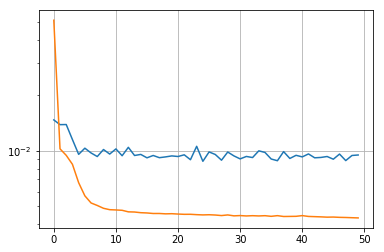

In [46]:
## Stateless, dropout = 0.5

Stop here

In [4]:
# fit model
# configure
n_lag = 120
n_seq = 60
n_test = 1
n_epochs = 5
n_batch = 1
n_neurons = 32

np.random.shuffle(train)
import math

Num_Predictions = 25 # number of predictions to make

list_num = list(range(1,Num_Predictions+1)) # create a list between one and Num_predictions to loop through
training_list = [] # list of training models
models_list= [] # list of models
#################
Num_train = 10000
#print(Num_train)
#print(Last_length)
#print(list_num)
for i in list_num: #loop through the number of models wanting to be run
    print("Training model:")
    print(i)
    np.random.shuffle(train)
    a = train[0:Num_train,:]
    b = fit_lstm(a, n_lag, n_seq, n_batch, n_epochs, n_neurons) #fit model
    models_list.append(b)
    print("Trained model:")
    print(i)

Training model:
1
Epoch 1/1
10000/10000 [==============================] - 1013s 101ms/step - loss: 0.0139 -
Epoch 1/1
10000/10000 [==============================] - 1019s 102ms/step - loss: 0.0080
Epoch 1/1
10000/10000 [==============================] - 1021s 102ms/step - loss: 0.0075
Epoch 1/1
10000/10000 [==============================] - 1022s 102ms/step - loss: 0.0074
Epoch 1/1
10000/10000 [==============================] - 1022s 102ms/step - loss: 0.0071
Trained model:
1
Training model:
2
Epoch 1/1
10000/10000 [==============================] - 976s 98ms/step - loss: 0.0139
Epoch 1/1
10000/10000 [==============================] - 974s 97ms/step - loss: 0.0083
Epoch 1/1
10000/10000 [==============================] - 975s 98ms/step - loss: 0.0076
Epoch 1/1
10000/10000 [==============================] - 975s 98ms/step - loss: 0.0075 ET
Epoch 1/1
10000/10000 [==============================] - 976s 98ms/step - loss: 0.0072
Trained model:
2
Training model:
3
Epoch 1/1
10000/10000 [====

Epoch 1/1
10000/10000 [==============================] - 1035s 103ms/step - loss: 0.0138
Epoch 1/1
10000/10000 [==============================] - 1032s 103ms/step - loss: 0.0082 
Epoch 1/1
10000/10000 [==============================] - 1032s 103ms/step - loss: 0.0079
Epoch 1/1
10000/10000 [==============================] - 1032s 103ms/step - loss: 0.0076
Epoch 1/1
10000/10000 [==============================] - 1032s 103ms/step - loss: 0.0076
Trained model:
18
Training model:
19
Epoch 1/1
10000/10000 [==============================] - 1037s 104ms/step - loss: 0.0138
Epoch 1/1
10000/10000 [==============================] - 1035s 104ms/step - loss: 0.0083
Epoch 1/1
10000/10000 [==============================] - 1035s 104ms/step - loss: 0.0076 - loss
Epoch 1/1
10000/10000 [==============================] - 1036s 104ms/step - loss: 0.0073
Epoch 1/1
10000/10000 [==============================] - 1035s 104ms/step - loss: 0.0071
Trained model:
19
Training model:
20
Epoch 1/1
10000/10000 [=====

In [5]:
import pandas
from pandas import DataFrame

df = pandas.read_csv('R:/Users/James R/3_Technical work/Machine Learning/Data/All Nash Data.csv', header=1)
df.columns = ['Well_name', 'Date', 'Oil_rate']
df.head()

import pandas as pd
#create  list of unique well names
UniqueNames = df.Well_name.unique()

#create a data frame dictionary to store  data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    #DataFrameDict[key] = df[:][df.Well_name == key]
    DataFrameDict[key] = df[:][df.Well_name == key]

In [6]:
for key in DataFrameDict.keys():
    print(DataFrameDict[key])

   Well_name      Date  Oil_rate
0    ATO_10H  May-2010       0.0
1    ATO_10H  Jun-2010       0.0
2    ATO_10H  Jul-2010       0.0
3    ATO_10H  Aug-2010    1028.0
4    ATO_10H  Sep-2010     329.0
5    ATO_10H  Oct-2010     285.0
6    ATO_10H  Nov-2010     254.0
7    ATO_10H  Dec-2010     275.0
8    ATO_10H  Jan-2011     269.0
9    ATO_10H  Feb-2011     271.0
10   ATO_10H  Mar-2011     276.0
11   ATO_10H  Apr-2011     247.0
12   ATO_10H  May-2011     157.0
13   ATO_10H  Jun-2011     252.0
14   ATO_10H  Jul-2011     222.0
15   ATO_10H  Aug-2011     221.0
16   ATO_10H  Sep-2011     206.0
17   ATO_10H  Oct-2011     229.0
18   ATO_10H  Nov-2011     227.0
19   ATO_10H  Dec-2011     234.0
20   ATO_10H  Jan-2012     261.0
21   ATO_10H  Feb-2012     204.0
22   ATO_10H  Mar-2012     253.0
23   ATO_10H  Apr-2012     247.0
24   ATO_10H  May-2012     248.0
25   ATO_10H  Jun-2012     211.0
26   ATO_10H  Jul-2012     225.0
27   ATO_10H  Aug-2012     223.0
28   ATO_10H  Sep-2012     223.0
29   ATO_1

       Well_name      Date  Oil_rate
1912  AWOTST-03H  Sep-2008     364.0
1913  AWOTST-03H  Oct-2008    1306.0
1914  AWOTST-03H  Nov-2008    1347.0
1915  AWOTST-03H  Dec-2008    1193.0
1916  AWOTST-03H  Jan-2009    1503.0
1917  AWOTST-03H  Feb-2009    1291.0
1918  AWOTST-03H  Mar-2009    1531.0
1919  AWOTST-03H  Apr-2009    1407.0
1920  AWOTST-03H  May-2009     969.0
1921  AWOTST-03H  Jun-2009    1236.0
1922  AWOTST-03H  Jul-2009     896.0
1923  AWOTST-03H  Aug-2009     574.0
1924  AWOTST-03H  Sep-2009     872.0
1925  AWOTST-03H  Oct-2009     820.0
1926  AWOTST-03H  Nov-2009     802.0
1927  AWOTST-03H  Dec-2009     871.0
1928  AWOTST-03H  Jan-2010     556.0
1929  AWOTST-03H  Feb-2010     543.0
1930  AWOTST-03H  Mar-2010     524.0
1931  AWOTST-03H  Apr-2010     521.0
1932  AWOTST-03H  May-2010     251.0
1933  AWOTST-03H  Jun-2010     593.0
1934  AWOTST-03H  Jul-2010     881.0
1935  AWOTST-03H  Aug-2010     602.0
1936  AWOTST-03H  Sep-2010     546.0
1937  AWOTST-03H  Oct-2010     511.0
1

     Well_name      Date  Oil_rate
4679  DICO_4ZH  Dec-2002    4496.0
4680  DICO_4ZH  Jan-2003    5845.0
4681  DICO_4ZH  Feb-2003    5279.0
4682  DICO_4ZH  Mar-2003    5062.0
4683  DICO_4ZH  Apr-2003    4966.0
4684  DICO_4ZH  May-2003    4740.0
4685  DICO_4ZH  Jun-2003    4324.0
4686  DICO_4ZH  Jul-2003    4302.0
4687  DICO_4ZH  Aug-2003    3753.0
4688  DICO_4ZH  Sep-2003    3643.0
4689  DICO_4ZH  Oct-2003    3434.0
4690  DICO_4ZH  Nov-2003    2875.0
4691  DICO_4ZH  Dec-2003    2764.0
4692  DICO_4ZH  Jan-2004    2594.0
4693  DICO_4ZH  Feb-2004    2168.0
4694  DICO_4ZH  Mar-2004    2527.0
4695  DICO_4ZH  Apr-2004    2477.0
4696  DICO_4ZH  May-2004    2361.0
4697  DICO_4ZH  Jun-2004    2322.0
4698  DICO_4ZH  Jul-2004    2317.0
4699  DICO_4ZH  Aug-2004    2063.0
4700  DICO_4ZH  Sep-2004    2081.0
4701  DICO_4ZH  Oct-2004    1842.0
4702  DICO_4ZH  Nov-2004    1931.0
4703  DICO_4ZH  Dec-2004    2011.0
4704  DICO_4ZH  Jan-2005    2110.0
4705  DICO_4ZH  Feb-2005    1816.0
4706  DICO_4ZH  Mar-

      Well_name      Date     Oil_rate
9741       GA08  Feb-1967  1735.607143
9742       GA08  Mar-1967  1885.129032
9743       GA08  Apr-1967  2158.433333
9744       GA08  May-1967  2026.193548
9745       GA08  Jun-1967  2214.033333
9746       GA08  Jul-1967  2238.387097
9747       GA08  Aug-1967  1647.387097
9748       GA08  Sep-1967   771.100000
9749       GA08  Oct-1967   860.129032
9750       GA08  Nov-1967   678.933333
9751       GA08  Dec-1967   639.967742
9752       GA08  Jan-1968   655.870968
9753       GA08  Feb-1968   765.965517
9754       GA08  Mar-1968   855.290323
9755       GA08  Apr-1968   856.566667
9756       GA08  May-1968  1079.612903
9757       GA08  Jun-1968  1089.166667
9758       GA08  Jul-1968  1948.838710
9759       GA08  Aug-1968  1296.548387
9760       GA08  Sep-1968  1175.133333
9761       GA08  Oct-1968  1142.419355
9762       GA08  Nov-1968  1220.600000
9763       GA08  Dec-1968  1309.741935
9764       GA08  Jan-1969  1225.000000
9765       GA08  Feb-1969

      Well_name      Date     Oil_rate
17629      GA24  Feb-1967  1240.357143
17630      GA24  Mar-1967  1900.451613
17631      GA24  Apr-1967  1250.533333
17632      GA24  May-1967  1946.064516
17633      GA24  Jun-1967  1875.866667
17634      GA24  Jul-1967  1673.903226
17635      GA24  Aug-1967   678.000000
17636      GA24  Sep-1967    66.666667
17637      GA24  Oct-1967     0.000000
17638      GA24  Nov-1967   877.266667
17639      GA24  Dec-1967  1194.322581
17640      GA24  Jan-1968  1431.000000
17641      GA24  Feb-1968  1721.931034
17642      GA24  Mar-1968  1851.387097
17643      GA24  Apr-1968  1744.500000
17644      GA24  May-1968  1512.451613
17645      GA24  Jun-1968  1588.733333
17646      GA24  Jul-1968  1586.483871
17647      GA24  Aug-1968  1589.516129
17648      GA24  Sep-1968  1585.866667
17649      GA24  Oct-1968  1767.387097
17650      GA24  Nov-1968  1851.300000
17651      GA24  Dec-1968  2055.967742
17652      GA24  Jan-1969  2046.709677
17653      GA24  Feb-1969

      Well_name      Date    Oil_rate
25972      GA44  Mar-1971    0.000000
25973      GA44  Apr-1971    0.000000
25974      GA44  May-1971    0.000000
25975      GA44  Jun-1971    0.000000
25976      GA44  Jul-1971    0.000000
25977      GA44  Aug-1971    0.000000
25978      GA44  Sep-1971    0.000000
25979      GA44  Oct-1971    0.000000
25980      GA44  Nov-1971  363.066667
25981      GA44  Dec-1971  291.193548
25982      GA44  Jan-1972    0.000000
25983      GA44  Feb-1972    0.000000
25984      GA44  Mar-1972    0.000000
25985      GA44  Apr-1972    0.000000
25986      GA44  May-1972    0.000000
25987      GA44  Jun-1972    0.000000
25988      GA44  Jul-1972    0.000000
25989      GA44  Aug-1972    0.000000
25990      GA44  Sep-1972    0.000000
25991      GA44  Oct-1972    0.000000
25992      GA44  Nov-1972    0.000000
25993      GA44  Dec-1972    0.000000
25994      GA44  Jan-1973    0.000000
25995      GA44  Feb-1973    0.000000
25996      GA44  Mar-1973    0.000000
25997      G

      Well_name      Date  Oil_rate
31563    IV-029  Jan-1967       NaN
31564    IV-029  Feb-1967       NaN
31565    IV-029  Mar-1967       NaN
31566    IV-029  Apr-1967       NaN
31567    IV-029  May-1967       NaN
31568    IV-029  Jun-1967       NaN
31569    IV-029  Jul-1967       NaN
31570    IV-029  Aug-1967       NaN
31571    IV-029  Sep-1967       NaN
31572    IV-029  Oct-1967       NaN
31573    IV-029  Nov-1967       NaN
31574    IV-029  Dec-1967       NaN
31575    IV-029  Jan-1968       NaN
31576    IV-029  Feb-1968       NaN
31577    IV-029  Mar-1968       NaN
31578    IV-029  Apr-1968       NaN
31579    IV-029  May-1968       NaN
31580    IV-029  Jun-1968       NaN
31581    IV-029  Jul-1968       NaN
31582    IV-029  Aug-1968       NaN
31583    IV-029  Sep-1968       NaN
31584    IV-029  Oct-1968       NaN
31585    IV-029  Nov-1968       NaN
31586    IV-029  Dec-1968       NaN
31587    IV-029  Jan-1969       NaN
31588    IV-029  Feb-1969       NaN
31589    IV-029  Mar-1969   

      Well_name      Date     Oil_rate
39595      IV21  Jul-1971  1018.741935
39596      IV21  Aug-1971  1562.000000
39597      IV21  Sep-1971  2996.566667
39598      IV21  Oct-1971  2390.193548
39599      IV21  Nov-1971  1047.000000
39600      IV21  Dec-1971  2474.709677
39601      IV21  Jan-1972  2607.354839
39602      IV21  Feb-1972  2340.896552
39603      IV21  Mar-1972  1707.741935
39604      IV21  Apr-1972  1885.600000
39605      IV21  May-1972  2082.709677
39606      IV21  Jun-1972  1542.333333
39607      IV21  Jul-1972  1638.774194
39608      IV21  Aug-1972  1675.548387
39609      IV21  Sep-1972  1471.333333
39610      IV21  Oct-1972  1523.161290
39611      IV21  Nov-1972  1768.500000
39612      IV21  Dec-1972  1639.870968
39613      IV21  Jan-1973  1412.032258
39614      IV21  Feb-1973  1065.535714
39615      IV21  Mar-1973  1187.677419
39616      IV21  Apr-1973   963.666667
39617      IV21  May-1973   963.741935
39618      IV21  Jun-1973  1038.366667
39619      IV21  Jul-1973

      Well_name      Date    Oil_rate
48809      IV41  Nov-1984  182.533333
48810      IV41  Dec-1984  186.129032
48811      IV41  Jan-1985  127.000000
48812      IV41  Feb-1985  151.107143
48813      IV41  Mar-1985  116.322581
48814      IV41  Apr-1985  115.466667
48815      IV41  May-1985  148.483871
48816      IV41  Jun-1985  154.600000
48817      IV41  Jul-1985  148.645161
48818      IV41  Aug-1985  204.806452
48819      IV41  Sep-1985  176.100000
48820      IV41  Oct-1985  101.225806
48821      IV41  Nov-1985  165.933333
48822      IV41  Dec-1985  159.419355
48823      IV41  Jan-1986  120.709677
48824      IV41  Feb-1986  130.392857
48825      IV41  Mar-1986   95.322581
48826      IV41  Apr-1986  128.433333
48827      IV41  May-1986  113.419355
48828      IV41  Jun-1986  127.966667
48829      IV41  Jul-1986  175.322581
48830      IV41  Aug-1986  139.709677
48831      IV41  Sep-1986  109.500000
48832      IV41  Oct-1986   88.612903
48833      IV41  Nov-1986   91.033333
48834      I

      Well_name      Date  Oil_rate
50825    KOU012  Jun-2014     158.0
50826    KOU012  Jul-2014    1188.0
50827    KOU012  Aug-2014    2965.0
50828    KOU012  Sep-2014    3700.0
50829    KOU012  Oct-2014    4204.0
50830    KOU012  Nov-2014    3800.0
50831    KOU012  Dec-2014    2709.0
50832    KOU012  Jan-2015    2191.0
50833    KOU012  Feb-2015    3277.0
50834    KOU012  Mar-2015    3404.0
50835    KOU012  Apr-2015    3210.0
50836    KOU012  May-2015    2369.0
50837    KOU012  Jun-2015    2876.0
50838    KOU012  Jul-2015    2603.0
50839    KOU012  Aug-2015    2662.0
50840    KOU012  Sep-2015    2546.0
50841    KOU012  Oct-2015    2632.0
50842    KOU012  Nov-2015    2615.0
50843    KOU012  Dec-2015    3036.0
      Well_name      Date  Oil_rate
50844       MB2  May-1978       0.0
50845       MB2  Jun-1978       0.0
50846       MB2  Jul-1978       0.0
50847       MB2  Aug-1978       0.0
50848       MB2  Sep-1978       0.0
50849       MB2  Oct-1978       0.0
50850       MB2  Nov-1978   

      Well_name      Date  Oil_rate
53236     OZI11  Dec-2005     671.0
53237     OZI11  Jan-2006    1315.0
53238     OZI11  Feb-2006     956.0
53239     OZI11  Mar-2006     811.0
53240     OZI11  Apr-2006     794.0
53241     OZI11  May-2006     792.0
53242     OZI11  Jun-2006     744.0
53243     OZI11  Jul-2006     666.0
53244     OZI11  Aug-2006     696.0
53245     OZI11  Sep-2006     702.0
53246     OZI11  Oct-2006     865.0
53247     OZI11  Nov-2006     767.0
53248     OZI11  Dec-2006     646.0
53249     OZI11  Jan-2007     629.0
53250     OZI11  Feb-2007     702.0
53251     OZI11  Mar-2007     757.0
53252     OZI11  Apr-2007     787.0
53253     OZI11  May-2007       0.0
53254     OZI11  Jun-2007     703.0
53255     OZI11  Jul-2007     939.0
53256     OZI11  Aug-2007     772.0
53257     OZI11  Sep-2007     770.0
53258     OZI11  Oct-2007     814.0
53259     OZI11  Nov-2007     494.0
53260     OZI11  Dec-2007     547.0
53261     OZI11  Jan-2008     649.0
53262     OZI11  Feb-2008   

      Well_name      Date  Oil_rate
54724     OZI25  Aug-2007     136.0
54725     OZI25  Sep-2007    1297.0
54726     OZI25  Oct-2007    1338.0
54727     OZI25  Nov-2007    1352.0
54728     OZI25  Dec-2007    1435.0
54729     OZI25  Jan-2008    1489.0
54730     OZI25  Feb-2008    1340.0
54731     OZI25  Mar-2008     871.0
54732     OZI25  Apr-2008    1175.0
54733     OZI25  May-2008    1427.0
54734     OZI25  Jun-2008    1459.0
54735     OZI25  Jul-2008    1556.0
54736     OZI25  Aug-2008    1473.0
54737     OZI25  Sep-2008    1511.0
54738     OZI25  Oct-2008    1711.0
54739     OZI25  Nov-2008    1656.0
54740     OZI25  Dec-2008    1573.0
54741     OZI25  Jan-2009    1523.0
54742     OZI25  Feb-2009    1660.0
54743     OZI25  Mar-2009    1317.0
54744     OZI25  Apr-2009    1907.0
54745     OZI25  May-2009    1852.0
54746     OZI25  Jun-2009    1710.0
54747     OZI25  Jul-2009    1622.0
54748     OZI25  Aug-2009    1418.0
54749     OZI25  Sep-2009    1561.0
54750     OZI25  Oct-2009   

      Well_name      Date  Oil_rate
55731     OZI39  May-2012       0.0
55732     OZI39  Jun-2012     524.0
55733     OZI39  Jul-2012     668.0
55734     OZI39  Aug-2012     712.0
55735     OZI39  Sep-2012     865.0
55736     OZI39  Oct-2012     938.0
55737     OZI39  Nov-2012     848.0
55738     OZI39  Dec-2012     816.0
55739     OZI39  Jan-2013    1089.0
55740     OZI39  Feb-2013    1087.0
55741     OZI39  Mar-2013    1101.0
55742     OZI39  Apr-2013    1163.0
55743     OZI39  May-2013    1050.0
55744     OZI39  Jun-2013    1045.0
55745     OZI39  Jul-2013     999.0
55746     OZI39  Aug-2013    1043.0
55747     OZI39  Sep-2013     910.0
55748     OZI39  Oct-2013     730.0
55749     OZI39  Nov-2013     924.0
55750     OZI39  Dec-2013     888.0
55751     OZI39  Jan-2014     828.0
55752     OZI39  Feb-2014     990.0
55753     OZI39  Mar-2014     897.0
55754     OZI39  Apr-2014     928.0
55755     OZI39  May-2014     786.0
55756     OZI39  Jun-2014     769.0
55757     OZI39  Jul-2014   

      Well_name      Date     Oil_rate
57316    RAB006  May-1989   580.436591
57317    RAB006  Jun-1989  1866.619480
57318    RAB006  Jul-1989  2129.534419
57319    RAB006  Aug-1989  2003.377765
57320    RAB006  Sep-1989  2206.215697
57321    RAB006  Oct-1989  2371.343467
57322    RAB006  Nov-1989  2117.363603
57323    RAB006  Dec-1989  2255.338883
57324    RAB006  Jan-1990  2173.455015
57325    RAB006  Feb-1990  1955.544666
57326    RAB006  Mar-1990  1593.078445
57327    RAB006  Apr-1990   531.137375
57328    RAB006  May-1990  2430.575216
57329    RAB006  Jun-1990  2097.641148
57330    RAB006  Jul-1990  1570.474131
57331    RAB006  Aug-1990  1054.134579
57332    RAB006  Sep-1990  1015.088643
57333    RAB006  Oct-1990  1061.655918
57334    RAB006  Nov-1990  1042.470318
57335    RAB006  Dec-1990  1038.852347
57336    RAB006  Jan-1991  1037.868512
57337    RAB006  Feb-1991   862.174041
57338    RAB006  Mar-1991  1048.180018
57339    RAB006  Apr-1991   986.742266
57340    RAB006  May-1991

      Well_name      Date     Oil_rate
62240    RAB025  Aug-1989  2595.052328
62241    RAB025  Sep-1989  4656.123583
62242    RAB025  Oct-1989  4734.481629
62243    RAB025  Nov-1989  4110.665297
62244    RAB025  Dec-1989  3584.060248
62245    RAB025  Jan-1990  3534.657826
62246    RAB025  Feb-1990  3403.444075
62247    RAB025  Mar-1990  3536.144810
62248    RAB025  Apr-1990  3549.156880
62249    RAB025  May-1990  3164.298971
62250    RAB025  Jun-1990  3311.441725
62251    RAB025  Jul-1990  3455.530010
62252    RAB025  Aug-1990  3600.330861
62253    RAB025  Sep-1990  3460.174500
62254    RAB025  Oct-1990  3134.141581
62255    RAB025  Nov-1990  3276.843779
62256    RAB025  Dec-1990  3155.653262
62257    RAB025  Jan-1991  2837.821169
62258    RAB025  Feb-1991  2820.231045
62259    RAB025  Mar-1991  2932.729564
62260    RAB025  Apr-1991  3004.083773
62261    RAB025  May-1991  2884.315431
62262    RAB025  Jun-1991  2752.666961
62263    RAB025  Jul-1991  2744.810875
62264    RAB025  Aug-1991

      Well_name      Date     Oil_rate
67047    RAB041  Aug-1989   529.435224
67048    RAB041  Sep-1989  4276.759760
67049    RAB041  Oct-1989  4362.567690
67050    RAB041  Nov-1989   826.998144
67051    RAB041  Dec-1989  2988.344919
67052    RAB041  Jan-1990  3296.389632
67053    RAB041  Feb-1990  3283.974525
67054    RAB041  Mar-1990  3180.679312
67055    RAB041  Apr-1990  2985.707878
67056    RAB041  May-1990  2345.913081
67057    RAB041  Jun-1990  2789.764455
67058    RAB041  Jul-1990  2757.270951
67059    RAB041  Aug-1990  2830.588014
67060    RAB041  Sep-1990  3848.436037
67061    RAB041  Oct-1990  3072.331925
67062    RAB041  Nov-1990  2952.898692
67063    RAB041  Dec-1990  2806.980558
67064    RAB041  Jan-1991  2614.276783
67065    RAB041  Feb-1991  2653.739744
67066    RAB041  Mar-1991  2655.968547
67067    RAB041  Apr-1991  2420.876705
67068    RAB041  May-1991  2819.655304
67069    RAB041  Jun-1991  2117.761569
67070    RAB041  Jul-1991  2900.978830
67071    RAB041  Aug-1991

      Well_name      Date     Oil_rate
71500    RAB057  Jan-1990    35.245099
71501    RAB057  Feb-1990  4395.189657
71502    RAB057  Mar-1990  5461.744035
71503    RAB057  Apr-1990  5074.159913
71504    RAB057  May-1990  3917.398216
71505    RAB057  Jun-1990  4633.293540
71506    RAB057  Jul-1990  4261.478287
71507    RAB057  Aug-1990  3744.429439
71508    RAB057  Sep-1990  3667.767377
71509    RAB057  Oct-1990  3904.625552
71510    RAB057  Nov-1990  3800.669177
71511    RAB057  Dec-1990  4011.358113
71512    RAB057  Jan-1991  3988.414606
71513    RAB057  Feb-1991  3081.266521
71514    RAB057  Mar-1991  3532.452968
71515    RAB057  Apr-1991  3598.399277
71516    RAB057  May-1991  3457.226210
71517    RAB057  Jun-1991  3239.052695
71518    RAB057  Jul-1991  3535.806152
71519    RAB057  Aug-1991  3471.836506
71520    RAB057  Sep-1991  3322.517821
71521    RAB057  Oct-1991  3283.052606
71522    RAB057  Nov-1991  3082.614883
71523    RAB057  Dec-1991  2842.513073
71524    RAB057  Jan-1992

      Well_name      Date      Oil_rate
76441    RAB077  Jul-1992   8950.006068
76442    RAB077  Aug-1992  13881.388545
76443    RAB077  Sep-1992  14206.650237
76444    RAB077  Oct-1992  14872.589113
76445    RAB077  Nov-1992  12129.659423
76446    RAB077  Dec-1992  10415.621458
76447    RAB077  Jan-1993   9022.426074
76448    RAB077  Feb-1993   8216.935911
76449    RAB077  Mar-1993   8134.174384
76450    RAB077  Apr-1993   6975.705130
76451    RAB077  May-1993   6776.322635
76452    RAB077  Jun-1993   6450.428763
76453    RAB077  Jul-1993   7027.127671
76454    RAB077  Aug-1993   6562.937932
76455    RAB077  Sep-1993   5951.570353
76456    RAB077  Oct-1993   5858.754461
76457    RAB077  Nov-1993   5330.623243
76458    RAB077  Dec-1993   4857.347532
76459    RAB077  Jan-1994   5387.098603
76460    RAB077  Feb-1994   4542.177671
76461    RAB077  Mar-1994   4429.295555
76462    RAB077  Apr-1994   3745.073000
76463    RAB077  May-1994   3535.549013
76464    RAB077  Jun-1994   3240.768778


      Well_name      Date      Oil_rate
80886    RAB095  Jun-1994  10045.379053
80887    RAB095  Jul-1994  12632.974839
80888    RAB095  Aug-1994  13018.195539
80889    RAB095  Sep-1994  12005.784313
80890    RAB095  Oct-1994  10309.662884
80891    RAB095  Nov-1994   8746.005603
80892    RAB095  Dec-1994   8070.739635
80893    RAB095  Jan-1995   7414.792006
80894    RAB095  Feb-1995   6918.353393
80895    RAB095  Mar-1995   6201.137935
80896    RAB095  Apr-1995   5748.949433
80897    RAB095  May-1995   4804.353365
80898    RAB095  Jun-1995   5348.077203
80899    RAB095  Jul-1995   4746.556465
80900    RAB095  Aug-1995   4566.334523
80901    RAB095  Sep-1995   4477.813123
80902    RAB095  Oct-1995   3142.343418
80903    RAB095  Nov-1995   2769.981168
80904    RAB095  Dec-1995   2488.848102
80905    RAB095  Jan-1996   1781.345815
80906    RAB095  Feb-1996   1483.748947
80907    RAB095  Mar-1996   1411.219960
80908    RAB095  Apr-1996   1076.431169
80909    RAB095  May-1996   1160.612973


      Well_name      Date     Oil_rate
83551    RAB107  May-1995  7851.821055
83552    RAB107  Jun-1995  9388.496483
83553    RAB107  Jul-1995  8389.339865
83554    RAB107  Aug-1995  5338.009471
83555    RAB107  Sep-1995  3829.105833
83556    RAB107  Oct-1995  3138.994580
83557    RAB107  Nov-1995  3592.145153
83558    RAB107  Dec-1995  3101.833742
83559    RAB107  Jan-1996  3466.058942
83560    RAB107  Feb-1996  3547.057893
83561    RAB107  Mar-1996  3435.945881
83562    RAB107  Apr-1996  3076.242426
83563    RAB107  May-1996  2654.532136
83564    RAB107  Jun-1996  2495.217587
83565    RAB107  Jul-1996  2714.159710
83566    RAB107  Aug-1996  2369.451423
83567    RAB107  Sep-1996  2132.831923
83568    RAB107  Oct-1996  2222.919439
83569    RAB107  Nov-1996  2189.224656
83570    RAB107  Dec-1996  2190.871021
83571    RAB107  Jan-1997  2956.480383
83572    RAB107  Feb-1997  2941.051948
83573    RAB107  Mar-1997  2860.244189
83574    RAB107  Apr-1997  2584.836801
83575    RAB107  May-1997

      Well_name      Date     Oil_rate
86947    RAB122  Apr-1996   835.312795
86948    RAB122  May-1996  9989.683535
86949    RAB122  Jun-1996  9065.855173
86950    RAB122  Jul-1996  5608.553858
86951    RAB122  Aug-1996  5318.397442
86952    RAB122  Sep-1996  5272.170510
86953    RAB122  Oct-1996  4614.734655
86954    RAB122  Nov-1996  4639.141027
86955    RAB122  Dec-1996  4731.901752
86956    RAB122  Jan-1997  4069.029706
86957    RAB122  Feb-1997  2373.540668
86958    RAB122  Mar-1997  2897.293590
86959    RAB122  Apr-1997  3095.518911
86960    RAB122  May-1997  2283.569424
86961    RAB122  Jun-1997  2779.040150
86962    RAB122  Jul-1997  1976.959871
86963    RAB122  Aug-1997  2070.983209
86964    RAB122  Sep-1997  2434.772257
86965    RAB122  Oct-1997  2588.659697
86966    RAB122  Nov-1997  2019.525719
86967    RAB122  Dec-1997  1734.678306
86968    RAB122  Jan-1998  1335.015043
86969    RAB122  Feb-1998  2157.874815
86970    RAB122  Mar-1998  2754.780670
86971    RAB122  Apr-1998

      Well_name      Date     Oil_rate
90493    RAB139  Apr-1997  3530.351743
90494    RAB139  May-1997  9068.986700
90495    RAB139  Jun-1997  6758.261327
90496    RAB139  Jul-1997  6083.133548
90497    RAB139  Aug-1997  5001.197987
90498    RAB139  Sep-1997  4727.064533
90499    RAB139  Oct-1997  4097.178829
90500    RAB139  Nov-1997  3683.141747
90501    RAB139  Dec-1997  3161.329347
90502    RAB139  Jan-1998  3034.321265
90503    RAB139  Feb-1998  2905.885778
90504    RAB139  Mar-1998  2774.674077
90505    RAB139  Apr-1998  2221.318442
90506    RAB139  May-1998  1690.440988
90507    RAB139  Jun-1998  1381.833467
90508    RAB139  Jul-1998   924.568145
90509    RAB139  Aug-1998   308.920896
90510    RAB139  Sep-1998   693.790226
90511    RAB139  Oct-1998   725.429657
90512    RAB139  Nov-1998    19.120695
90513    RAB139  Dec-1998     0.000000
90514    RAB139  Jan-1999    39.330230
90515    RAB139  Feb-1999     3.275957
90516    RAB139  Mar-1999     0.000000
90517    RAB139  Apr-1999

      Well_name      Date     Oil_rate
94011    RAB157  Jan-1998  5269.218126
94012    RAB157  Feb-1998  4823.431711
94013    RAB157  Mar-1998  4571.086500
94014    RAB157  Apr-1998  3933.055700
94015    RAB157  May-1998  2717.206255
94016    RAB157  Jun-1998  2200.897881
94017    RAB157  Jul-1998  2501.645071
94018    RAB157  Aug-1998  2008.434814
94019    RAB157  Sep-1998  2201.543083
94020    RAB157  Oct-1998  2526.833523
94021    RAB157  Nov-1998  2427.198993
94022    RAB157  Dec-1998  2761.619911
94023    RAB157  Jan-1999  3442.987481
94024    RAB157  Feb-1999  2167.421837
94025    RAB157  Mar-1999  2547.340575
94026    RAB157  Apr-1999  2805.112725
94027    RAB157  May-1999  2174.267285
94028    RAB157  Jun-1999  3007.505290
94029    RAB157  Jul-1999  3117.236850
94030    RAB157  Aug-1999  2451.977572
94031    RAB157  Sep-1999  1713.664664
94032    RAB157  Oct-1999  1848.514684
94033    RAB157  Nov-1999  2022.257588
94034    RAB157  Dec-1999  1651.412434
94035    RAB157  Jan-2000

      Well_name      Date     Oil_rate
97495    RAB177  Jan-1999  1620.646392
97496    RAB177  Feb-1999  5207.498011
97497    RAB177  Mar-1999  2950.478817
97498    RAB177  Apr-1999   544.334229
97499    RAB177  May-1999   593.683446
97500    RAB177  Jun-1999   605.614146
97501    RAB177  Jul-1999  2422.306889
97502    RAB177  Aug-1999  2461.437798
97503    RAB177  Sep-1999  1982.524598
97504    RAB177  Oct-1999  1583.494706
97505    RAB177  Nov-1999  1265.494182
97506    RAB177  Dec-1999  1145.005420
97507    RAB177  Jan-2000  1070.460288
97508    RAB177  Feb-2000  1476.806719
97509    RAB177  Mar-2000  1722.447173
97510    RAB177  Apr-2000  1905.391110
97511    RAB177  May-2000  1671.057242
97512    RAB177  Jun-2000  1625.994899
97513    RAB177  Jul-2000  3274.283719
97514    RAB177  Aug-2000  3810.458855
97515    RAB177  Sep-2000  1122.034084
97516    RAB177  Oct-2000   930.560812
97517    RAB177  Nov-2000  1317.258362
97518    RAB177  Dec-2000  1302.715555
97519    RAB177  Jan-2001

       Well_name      Date     Oil_rate
100536    RAB194  Nov-2002  2485.764761
100537    RAB194  Dec-2002  2714.977438
100538    RAB194  Jan-2003  2987.965365
100539    RAB194  Feb-2003  3423.361374
100540    RAB194  Mar-2003  1983.615167
100541    RAB194  Apr-2003  2714.261706
100542    RAB194  May-2003  2559.381595
100543    RAB194  Jun-2003  2619.434553
100544    RAB194  Jul-2003  1722.017322
100545    RAB194  Aug-2003  1506.045729
100546    RAB194  Sep-2003  1210.044742
100547    RAB194  Oct-2003  1390.856883
100548    RAB194  Nov-2003  1023.370195
100549    RAB194  Dec-2003   925.011419
100550    RAB194  Jan-2004   383.372834
100551    RAB194  Feb-2004   287.990645
100552    RAB194  Mar-2004   509.053712
100553    RAB194  Apr-2004   429.027726
100554    RAB194  May-2004   317.017470
100555    RAB194  Jun-2004   375.701475
100556    RAB194  Jul-2004   448.352187
100557    RAB194  Aug-2004   559.082824
100558    RAB194  Sep-2004   578.577826
100559    RAB194  Oct-2004   417.442052


       Well_name      Date     Oil_rate
102723    RAB211  Aug-2005    18.604943
102724    RAB211  Sep-2005  1318.502246
102725    RAB211  Oct-2005  1128.265977
102726    RAB211  Nov-2005  1268.529361
102727    RAB211  Dec-2005  1281.455450
102728    RAB211  Jan-2006   834.328341
102729    RAB211  Feb-2006     0.032741
102730    RAB211  Mar-2006     0.053821
102731    RAB211  Apr-2006     0.057826
102732    RAB211  May-2006     0.055733
102733    RAB211  Jun-2006     0.061827
102734    RAB211  Jul-2006     0.028768
102735    RAB211  Aug-2006     0.030783
102736    RAB211  Sep-2006     0.000000
102737    RAB211  Oct-2006     0.030682
102738    RAB211  Nov-2006     0.030529
102739    RAB211  Dec-2006     0.027774
102740    RAB211  Jan-2007   349.117107
102741    RAB211  Feb-2007  1321.328542
102742    RAB211  Mar-2007  1062.715177
102743    RAB211  Apr-2007   694.823443
102744    RAB211  May-2007   815.530762
102745    RAB211  Jun-2007   841.864156
102746    RAB211  Jul-2007   776.484390


       Well_name      Date   Oil_rate
104750    RAB230  Mar-2008  27.895932
104751    RAB230  Apr-2008   0.011845
104752    RAB230  May-2008   0.101949
104753    RAB230  Jun-2008   1.281333
104754    RAB230  Jul-2008   0.000323
104755    RAB230  Aug-2008   0.000323
104756    RAB230  Sep-2008   0.000000
104757    RAB230  Oct-2008   0.000000
104758    RAB230  Nov-2008   0.000000
104759    RAB230  Dec-2008   0.000000
104760    RAB230  Jan-2009   0.000000
104761    RAB230  Feb-2009   0.000000
104762    RAB230  Mar-2009   0.000000
104763    RAB230  Apr-2009   0.000000
104764    RAB230  May-2009   0.000000
104765    RAB230  Jun-2009   0.000000
104766    RAB230  Jul-2009   0.000000
104767    RAB230  Aug-2009   0.000000
104768    RAB230  Sep-2009   0.000000
104769    RAB230  Oct-2009   0.000000
104770    RAB230  Nov-2009   0.000000
104771    RAB230  Dec-2009   0.000000
104772    RAB230  Jan-2010   0.000000
104773    RAB230  Feb-2010   0.000000
104774    RAB230  Mar-2010   0.000000
104775    RA

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


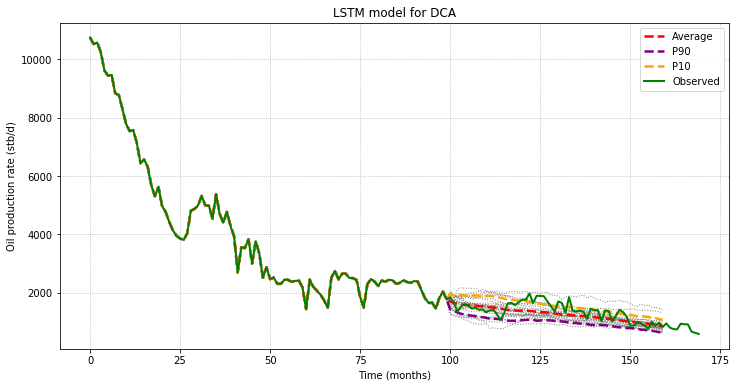

In [13]:
# Select a well forecast start time

Well = 'ATO_4H'

kick_off = 100


forecast_length = 60


#Import well prod data from dictionary
prod_data=DataFrameDict[Well]['Oil_rate'].values
#Check if prod hist is long enough for prediction start time
if len(prod_data) < kick_off:
    print("Prod history shorter than chosen prediction start time. Select early start time")
    print(len(prod_data))

# Pad data with zeros at front
prod_data = np.pad(prod_data, (n_lag-1,0), 'constant', constant_values=( 0, 0))

val1 = kick_off - n_lag

Prediction_list= [] # list of Preditctions

j=1

for model in models_list:
    
    pred_input = prod_data[kick_off:(kick_off+n_lag)]  #Select portion a prod hist for model input

    pred_input = np.where(pred_input<1,1,pred_input) # make all values less than 1 equal to one
    pred_input = np.log10(pred_input) # scale logarithmically
    scaler_value = np.max(pred_input)
    pred_input = pred_input / scaler_value # Scale to [0,1]
    
    pred_input = pred_input.reshape(1, n_lag, 1)
    pred_output = model.predict(pred_input,1) #Make prediction
    prediction = list(pred_output) # Covert model output to list
    prediction = np.append(list(pred_input),prediction) # Make single luist of input  and output
    
    #pyplot.figure(figsize=(12,6))
    #pyplot.plot(prediction)

    if forecast_length > n_seq:
        n_loop = np.floor(forecast_length/n_seq) # Number of loops required to generate enough forecast
        n_loop = n_loop.astype(int)

        for i in range(0,n_loop):
            pred_input = prediction[-n_lag:] # Get last n_lag values in input/output sequence
            pred_input = pred_input.reshape(1, n_lag, 1) # Reshape these
            pred_output = model.predict(pred_input,1) # Make prediction
            pred_temp = pred_output.tolist()
            prediction = np.append(prediction,pred_temp)
    
    #Counter
    print(j)
    j=j+1
    
    prediction = prediction*scaler_value
    prediction = np.power(10, prediction)
    Prediction_list.append(prediction)


pred_average=np.average(Prediction_list,axis=0)
pred_std=np.std(Prediction_list,axis=0)
pred_p90=pred_average - 1.24*pred_std
pred_p10=pred_average + 1.24*pred_std


A = np.array(Prediction_list)

pyplot.figure(figsize=(12,6))

for i in range(Num_Predictions):
    pyplot.plot(A[i,(n_lag-kick_off):], color='grey', linestyle = ":", linewidth=1.0 )
    
pyplot.plot(pred_average[(n_lag-kick_off):], color='red', label="Average", linestyle = "--", linewidth=2.5)
pyplot.plot(pred_p90[(n_lag-kick_off):], color='purple', label="P90", linestyle = "--", linewidth=2.5)
pyplot.plot(pred_p10[(n_lag-kick_off):], color='orange', label="P10", linestyle = "--", linewidth=2.5)

pyplot.plot(prod_data[(n_lag):], label="Observed", linewidth=2.0, color='green')
    
pyplot.ylabel('Oil production rate (stb/d)')
pyplot.xlabel('Time (months)')
pyplot.legend(loc='upper right')
pyplot.title('LSTM model for DCA')
pyplot.title('LSTM model for DCA')
pyplot.grid(linestyle='dotted')

pyplot.savefig('C:/Users/jramsay/Documents/Test.png')

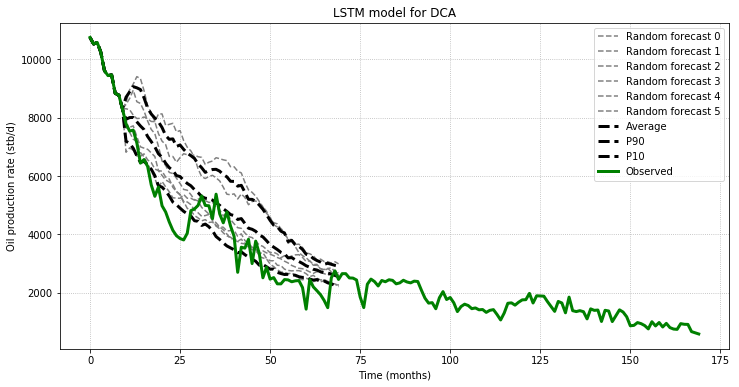

In [122]:
A = np.array(Prediction_list)

pyplot.figure(figsize=(12,6))

for i in range(Num_Predictions):
    pyplot.plot(A[i,(n_lag-kick_off):], color='grey', label="Random forecast " + str(i), linestyle = "--" )
    
pyplot.plot(pred_average[(n_lag-kick_off):], color='black', label="Average", linestyle = "--", linewidth=3.0)
pyplot.plot(pred_p90[(n_lag-kick_off):], color='black', label="P90", linestyle = "--", linewidth=3.0)
pyplot.plot(pred_p10[(n_lag-kick_off):], color='black', label="P10", linestyle = "--", linewidth=3.0)

pyplot.plot(prod_data[(n_lag):], label="Observed", linewidth=3.0, color='green')
    
pyplot.ylabel('Oil production rate (stb/d)')
pyplot.xlabel('Time (months)')
pyplot.legend(loc='upper right')
pyplot.title('LSTM model for DCA')
pyplot.title('LSTM model for DCA')
pyplot.grid(linestyle='dotted')




In [89]:
help(Prediction_list)

Help on list object:

class list(object)
 |  list() -> new empty list
 |  list(iterable) -> new list initialized from iterable's items
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iadd__(self, value, /)
 |      Implement self+=value.
 |  
 |  __imul__(self, value, /)
 |      Implement self*=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __le__(self, value, /

Text(0.5,1,'LSTM model for DCA')

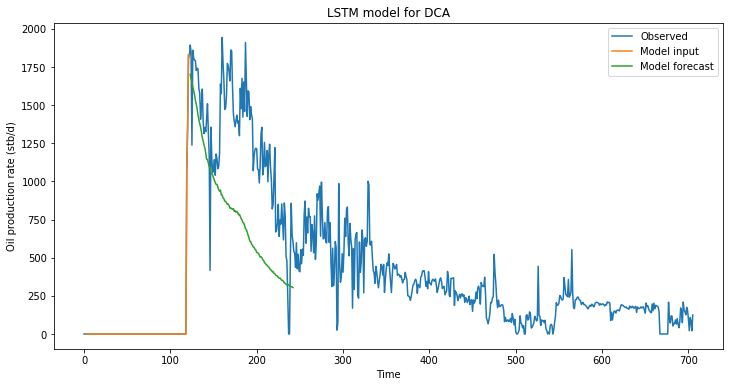

In [69]:
import numpy as np
i=3
forecasts = list()
len(forecasts)
X = Test_data[i, 0:n_lag]
X2 = np.append(X,range(120))
X2 = X2.reshape(1, len(X2))
X3 = scaler.transform(X2)
X4 = X3.reshape(1, np.shape(X3)[1], 1)
X5= X4[:,0:120,:]

# make forecast
forecast = model.predict(X5, 1)
#
var1 = np.append(X, forecast)
#
var1 = var1.reshape(1, len(var1))
#
# invert scaling
var2 = scaler.inverse_transform(var1)
var3 = np.append(X,var2[:,120:240])
#var2[0]
#pyplot.plot(var2)
pyplot.figure(figsize=(12,6))
pyplot.plot(series, label="Observed")
pyplot.plot(range(i,i+120),var3[0:120], label="Model input")
pyplot.plot(range(i+120,i+240),var3[120:240], label="Model forecast")
pyplot.ylabel('Oil production rate (stb/d)')
pyplot.xlabel('Time')
pyplot.legend(loc='upper right')
pyplot.title('LSTM model for DCA')
#len(var1)
#pyplot.ylim((0,500))
#pyplot.xlim((220,350))

(0, 600)

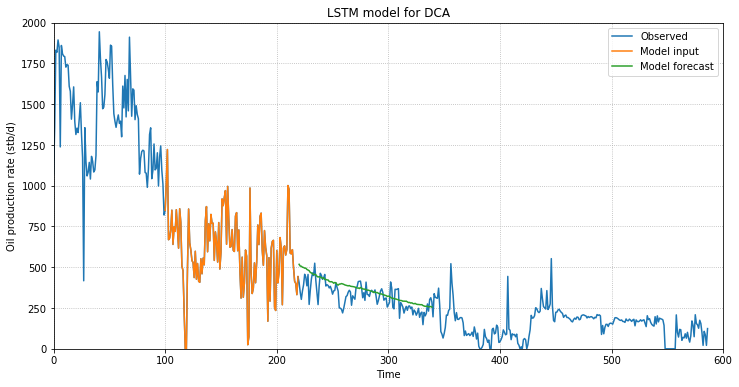

In [41]:
pyplot.figure(figsize=(12,6))
pyplot.plot(series, label="Observed")
pyplot.plot(range(i,i+120),var3[0:120], label="Model input")
pyplot.plot(range(i+120,i+240),var3[120:240], label="Model forecast")
pyplot.ylabel('Oil production rate (stb/d)')
pyplot.xlabel('Time')
pyplot.legend(loc='upper right')
pyplot.title('LSTM model for DCA')
pyplot.grid(linestyle='dotted')
pyplot.ylim((0,2000))
pyplot.xlim((0,600))
#pyplot.savefig('C:/Users/jramsay/Documents/Test.png')

In [13]:
from keras.models import save_model
model.save('my_model.h5')